# 09-proximityhexs_analysis

This notebook __loads hexs proximity analysis__ for a given walking_speed and resolution, __scales count__ (count_pois) data (MinMaxScalar Manually) and __sums count__ of amenities at a 15 minutes distance __by Social Function and Theme.__

The resulting code was used on __Script 25-nodes_to_hex.py__

## Import libraries

In [10]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

## Notebook config

In [38]:
walking_speed = 4.5
str_walking_speed = str(walking_speed).replace('.','_')

#parameters_dict = {social_functions:{themes:[sources]}}
parameters_dict = {'supplies':{'groceries':['carniceria','hogar','local_mini_market','ferias','supermercado']},# ferias no está
                   'caring':{'health':['clinica_priv','clinica_pub','hospital_priv','hospital_pub','consult_ado_priv','consult_ado_pub','residencia_adumayor','farmacia'],
                            'exercise':['club_deportivo','eq_deportivo_pub','eq_deportivo_priv']},
                   'living':{'errands_paperwork':['civic_office','tax_collection','social_security','banco'],
                             'fresh_air':['ep_plaza_small','ep_plaza_big']},#ep_plaza_small,ep_plaza_big no están
                   'enjoying':{'culture':['museos_priv','museos_pub','bibliotecas','sitios_historicos'],
                               'entertainment':['cines','librerias','restaurantes_bar_cafe']},
                   'learning':{'education':['edu_basica_priv','edu_basica_pub','edu_media_priv','edu_media_pub','jardin_inf_pub','jardin_inf_priv','edu_especial_priv','edu_especial_pub']},
                   'working':{'sustainable_mobility':['ciclovias','paradas_tp','paradas_tp_tren','paradas_tp_metro']}}#ciclovias no está

# When this sources are ready, delete list and remove "if source not in not_yet_list:" lines of code.
not_yet_list = ['ferias','ep_plaza_small','ep_plaza_big','ciclovias']

## Load data

In [62]:
# Area of interest (aoi)
proxhexs_schema = 'projects_research'
proxhexs_table = f'santiago_hexproximity_{str_walking_speed}_kmh'
res = 8

# Load hexs proximity for current walking_speed
query = f"SELECT * FROM {proxhexs_schema}.{proxhexs_table} WHERE \"res\"={res}"
proxhexs = aup.gdf_from_query(query)

# Show
print(proxhexs.shape)
proxhexs.head(1)

(4291, 82)


,hex_id,geometry,supermercado_time,supermercado_count_15min,clinica_priv_time,clinica_priv_count_15min,clinica_pub_time,clinica_pub_count_15min,hospital_priv_time,hospital_priv_count_15min,...,librerias_time,librerias_count_15min,local_mini_market_time,local_mini_market_count_15min,bakeries_time,bakeries_count_15min,restaurantes_bar_cafe_time,restaurantes_bar_cafe_count_15min,res,city
0,88b2c0b001fffff,"POLYGON ((-71.00896 -33.70843, -71.01339 -33.7...",105.780441,0.0,130.5914,0.0,90.375835,0.0,570.971609,0.0,...,550.44296,0.0,110.764741,0.0,112.68874,0.0,64.508497,0.0,8,Santiago


## MinMaxScaler (Manually)

In [63]:
proxhexs_countprocess = proxhexs.copy()
scalar_count_column_list = []

for social_function in parameters_dict.keys():
    print(f"--- {social_function}")
    for theme in parameters_dict[social_function]:
        print(f"------ {theme}")
        for source in parameters_dict[social_function][theme]:
            if source not in not_yet_list:

                # Set col name of interest and find min and max values
                count_colname = f"{source}_count_15min"
                min_val = proxhexs_countprocess[count_colname].min()
                max_val = proxhexs_countprocess[count_colname].max()
                # Calculate MinMax Scalar
                proxhexs_countprocess[f"{source}_scalarcount"] = proxhexs_countprocess[count_colname].apply(lambda x: ((x - val_min) /(val_max - val_min)))
                # Drop original count col
                proxhexs_countprocess.drop(columns=[count_colname],inplace=True)
                # Add
                scalar_count_column_list.append(f"{source}_scalarcount")

# Keep columns of interest only
proxhexs_countprocess = proxhexs_countprocess[['hex_id','geometry']+scalar_count_column_list+['res','city']]

# Show
print(proxhexs_countprocess.shape)
proxhexs_countprocess.head(1)

--- supplies
------ groceries
--- caring
------ health
------ exercise
--- living
------ errands_paperwork
------ fresh_air
--- enjoying
------ culture
------ entertainment
--- learning
------ education
--- working
------ sustainable_mobility
(4291, 41)


,hex_id,geometry,carniceria_scalarcount,hogar_scalarcount,local_mini_market_scalarcount,supermercado_scalarcount,clinica_priv_scalarcount,clinica_pub_scalarcount,hospital_priv_scalarcount,hospital_pub_scalarcount,...,edu_media_pub_scalarcount,jardin_inf_pub_scalarcount,jardin_inf_priv_scalarcount,edu_especial_priv_scalarcount,edu_especial_pub_scalarcount,paradas_tp_scalarcount,paradas_tp_tren_scalarcount,paradas_tp_metro_scalarcount,res,city
0,88b2c0b001fffff,"POLYGON ((-71.00896 -33.70843, -71.01339 -33.7...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,Santiago


## Sum by theme and social function

In [66]:
proxhexs_countanalysis = proxhexs_countprocess.copy()
sum_count_column_list = []

for social_function in parameters_dict.keys():
    # Set social function sources list
    sf_sources_list = []
    
    for theme in parameters_dict[social_function]:
        # Set theme_sources_list and feed sf_sources_list
        theme_sources_list = []
        for source in parameters_dict[social_function][theme]:
            if source not in not_yet_list:
                theme_sources_list.append(f"{source}_scalarcount")
                sf_sources_list.append(f"{source}_scalarcount")
        
        # Find sum of count anlysis for theme
        proxhexs_countanalysis[f"{theme}_count"] = proxhexs_countanalysis[theme_sources_list].sum(axis=1)
        sum_count_column_list.append(f"{theme}_count")
        
    # Find sum of count anlysis for social function
    proxhexs_countanalysis[f"{social_function}_count"] = proxhexs_countanalysis[sf_sources_list].sum(axis=1)
    sum_count_column_list.append(f"{social_function}_count")

# Keep columns of interest only
proxhexs_countanalysis = proxhexs_countanalysis[['hex_id','geometry']+sum_count_column_list+['res','city']]

# Show
print(proxhexs_countanalysis.shape)
proxhexs_countanalysis.head(1)

(4291, 19)


,hex_id,geometry,groceries_count,supplies_count,health_count,exercise_count,caring_count,errands_paperwork_count,fresh_air_count,living_count,culture_count,entertainment_count,enjoying_count,education_count,learning_count,sustainable_mobility_count,working_count,res,city
0,88b2c0b001fffff,"POLYGON ((-71.00896 -33.70843, -71.01339 -33.7...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,Santiago


## Visualize

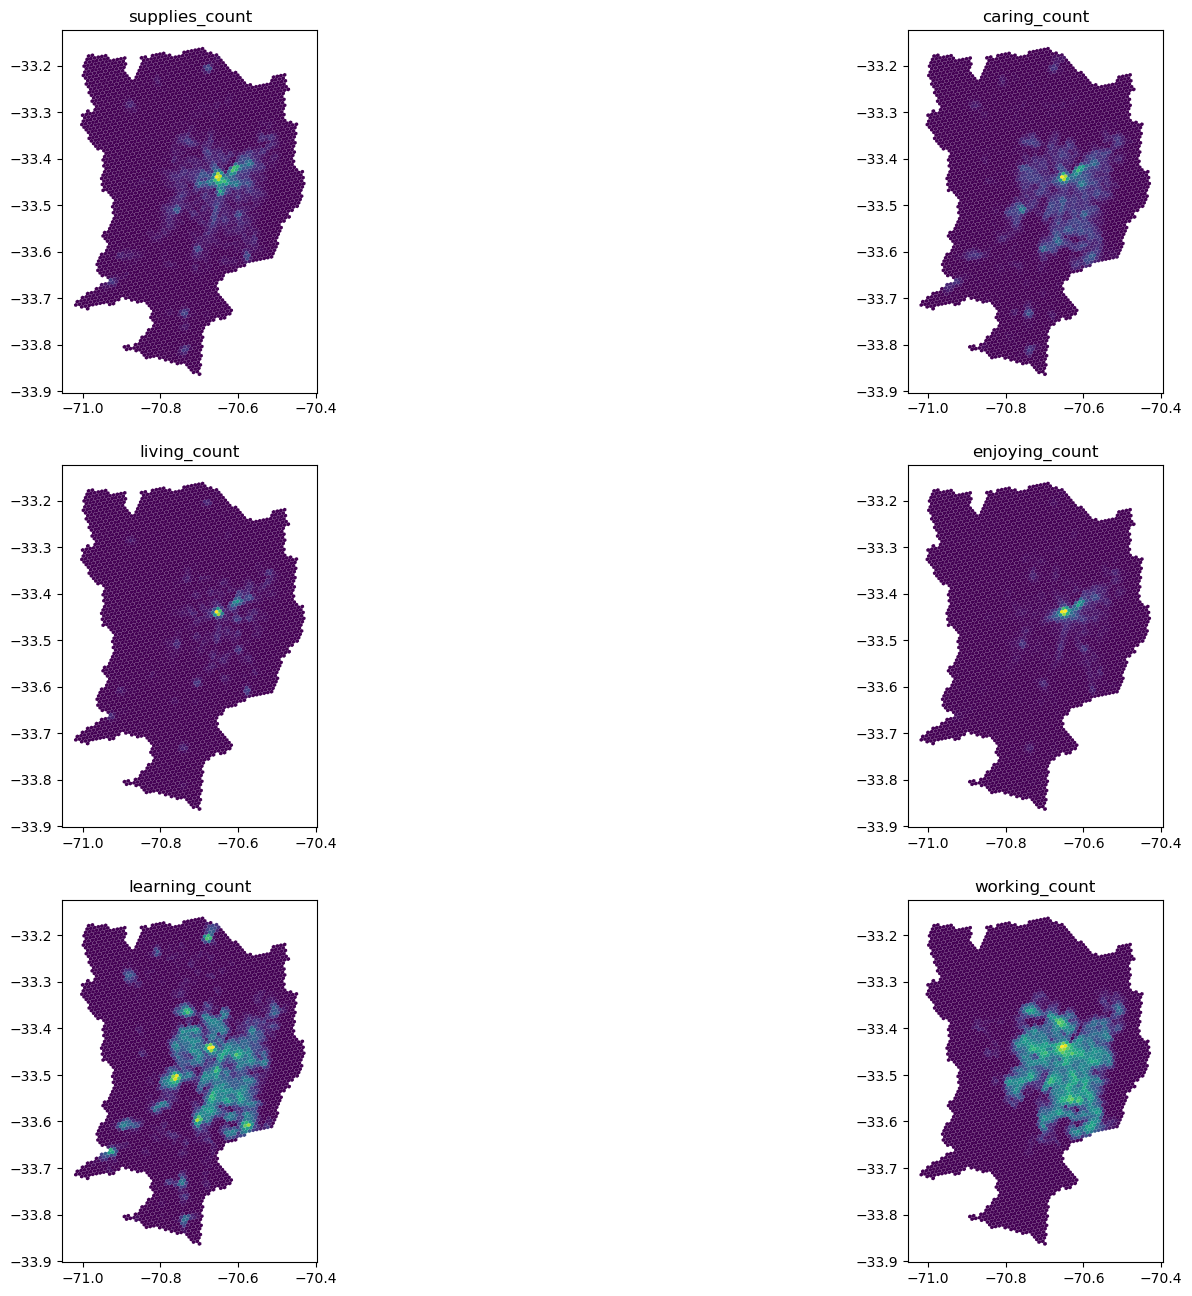

In [67]:
social_functions_count_cols = ['supplies_count','caring_count','living_count','enjoying_count','learning_count','working_count']

fig,ax = plt.subplots(3,2,figsize=(20,16))

i = 0
for row in range(len(ax)):
    for column in range(len(ax[0])):
        # Plot data
        proxhexs_countanalysis.plot(ax=ax[row][column],
                                    column=social_functions_count_cols[i])
        # Format - set title
        ax[row][column].set_title(social_functions_count_cols[i])
        
        i += 1